In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import ParameterGrid
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## 1. Data Preprocessing and Exploration 

In [2]:
# Function to preprocess the data
def preprocess_data(dataset, img_size=(256, 256)):
    images = []
    labels = []
    for image, label in dataset:
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize the image
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess the Caltech-101 dataset
def load_caltech101(img_size=(256, 256)):
    # Download and split the dataset
    (train_data, val_data, test_data), info = tfds.load('caltech101', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                              as_supervised=True, with_info=True)
    
    
    train_images, train_labels = preprocess_data(train_data, img_size)
    val_images, val_labels = preprocess_data(val_data, img_size)
    test_images, test_labels = preprocess_data(test_data, img_size)
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

    
(train_images, _), (val_images, _), (test_images, _) = load_caltech101()
print(f"Training data size: {train_images.shape}, \nValidation data size: {val_images.shape}, \nTesting data size: {test_images.shape}")


Training data size: (2141, 256, 256, 3), 
Validation data size: (459, 256, 256, 3), 
Testing data size: (459, 256, 256, 3)


No missing values in training images!

Visualizing Train Data:


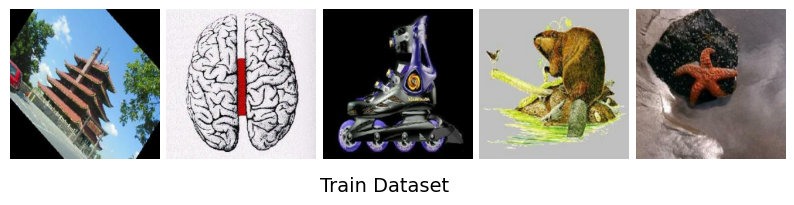

Visualizing Validation Data:


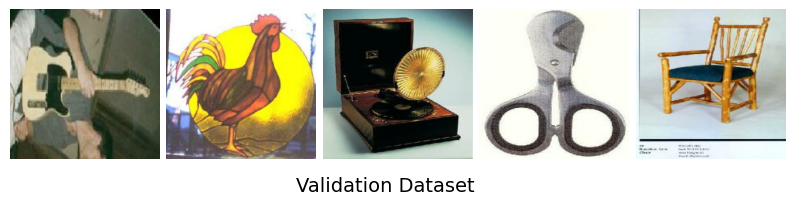

Visualizing Test Data:


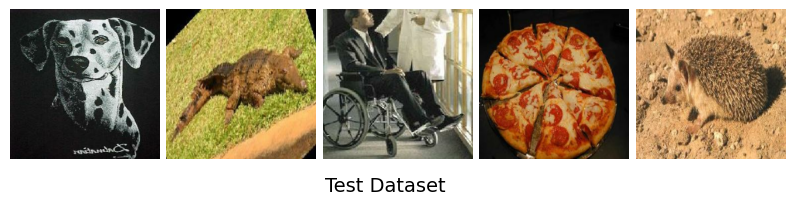

In [3]:
# Check for missing values
if np.isnan(train_images).any():
    print("Missing values detected in training images!\n")
else:
    print("No missing values in training images!\n")

# Visualize a few images from the dataset
def visualize_images(images, num_images=5, title="Dataset Visualization"):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.subplots_adjust(top=0.75, wspace=0.05, hspace=0.1)
    plt.suptitle(title, fontsize=14, y=0.2)
    plt.show()

# Visualize a few images from the train dataset
print("Visualizing Train Data:")
visualize_images(train_images, title="Train Dataset")

# Visualize a few images from the validation dataset (if needed)
print("Visualizing Validation Data:")
visualize_images(val_images, title="Validation Dataset")

# Visualize a few images from the test dataset
print("Visualizing Test Data:")
visualize_images(test_images, title="Test Dataset")

## 2. Unsupervised Learning Model Development 

In [4]:
# Define the  autoencoder model
def create_autoencoder(input_shape, encoding_dim=256):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 128x128x32
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 64x64x64

    # Bottleneck
    encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)  # 64x64x64
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 128x128x32

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # 256x256x3

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return autoencoder

# Set input shape
input_shape = (256, 256, 3)

# Build the improved autoencoder
autoencoder = create_autoencoder(input_shape, encoding_dim=512)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0715
Epoch 1: val_loss improved from inf to 0.01795, saving model to best_autoencoder_improved3.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - loss: 0.0709 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0145
Epoch 2: val_loss improved from 0.01795 to 0.00994, saving model to best_autoencoder_improved3.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 0.0145 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0087
Epoch 3: val_loss improved from 0.00994 to 0.00771, saving model to best_autoencoder_improved3.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 0.0087 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0066
Epoch 4: val_loss improved from 0.00771 to 0.00588, saving model to best_autoencoder_improved3.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 0.0066

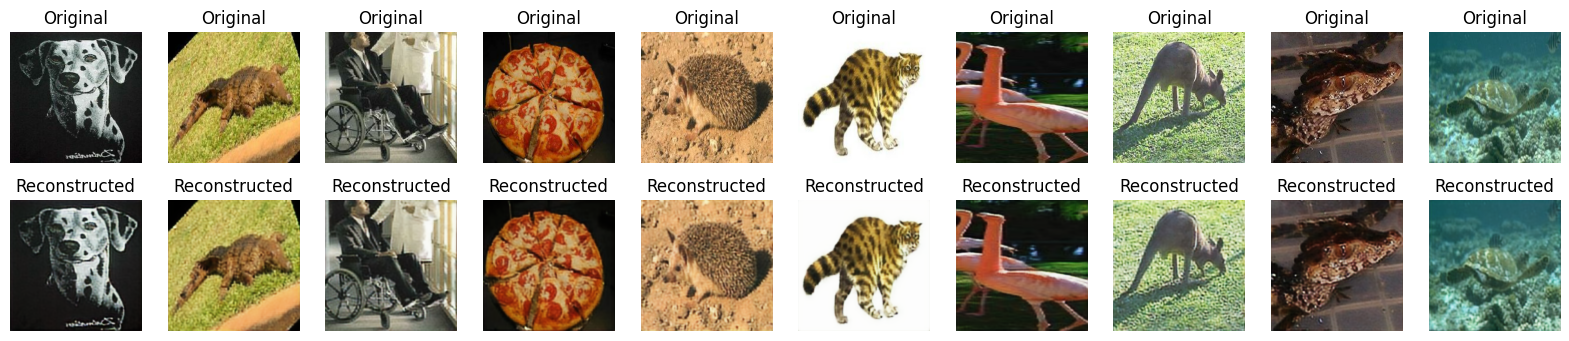

In [5]:
# Main function
def train_autoencoder():
    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        'best_autoencoder_improved3.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6, 
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1
    )

    # Train the autoencoder
    history = autoencoder.fit(
        train_images, train_images,
        epochs=30,
        batch_size=64,
        validation_data=(val_images, val_images),
        callbacks=[checkpoint_callback, lr_scheduler, early_stopping],
        verbose=1
    )

    # Load the best saved model
    best_autoencoder = tf.keras.models.load_model('best_autoencoder_improved3.keras')

    # Evaluate on test data
    test_loss = best_autoencoder.evaluate(test_images, test_images, verbose=1)
    print(f"Test Loss: {test_loss}")

    # Reconstruct test images
    reconstructed_images = best_autoencoder.predict(test_images)

    return reconstructed_images
    
# Visualize original and reconstructed images
def visualize_reconstruction(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

#Train autoencoder
reconstructed_images=train_autoencoder()

# Visualize the original and reconstructed images
visualize_reconstruction(test_images, reconstructed_images)


In [6]:
# Function to compute reconstruction errors
def compute_reconstruction_error(original, reconstructed):
    return np.mean(np.square(original - reconstructed), axis=(1, 2, 3))  # Per image error

reconstruction_errors = compute_reconstruction_error(test_images, reconstructed_images)

In [7]:
# Sort indices by error in descending order
sorted_indices = np.argsort(reconstruction_errors)  # Negative for descending order

# Sort errors, images, and reconstructions
sorted_errors = reconstruction_errors[sorted_indices]
sorted_X_test = test_images[sorted_indices]
sorted_reconstructed_images = reconstructed_images[sorted_indices]

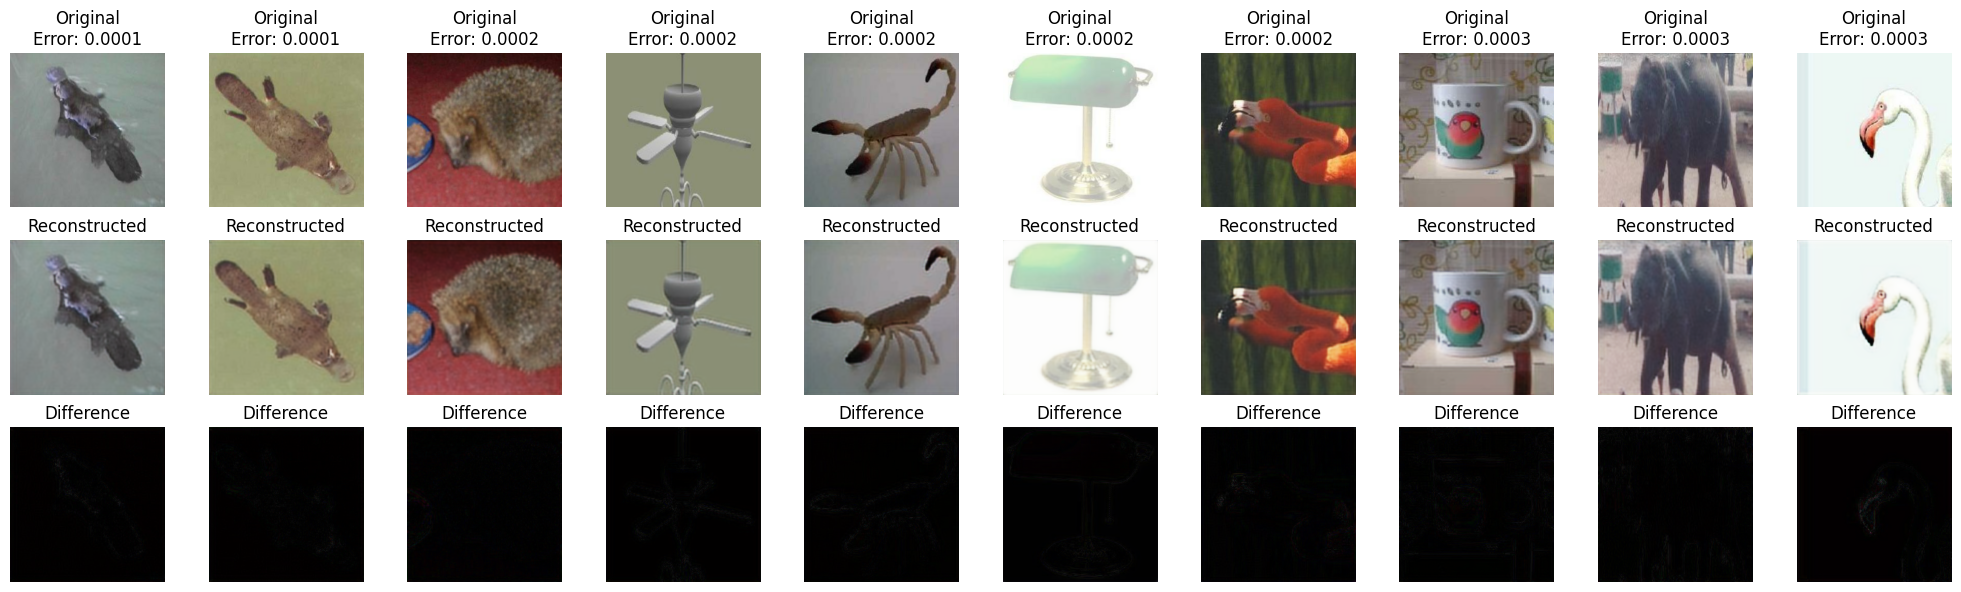

In [8]:
# Number of images to visualize
num_images = 10

# Create a figure
plt.figure(figsize=(20, 6))

for i in range(num_images):
    # Original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(sorted_X_test[i])
    plt.title(f"Original\nError: {sorted_errors[i]:.4f}")
    plt.axis("off")
    
    # Reconstructed image
    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(sorted_reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
    
    # Difference image (optional for visualization)
    difference = np.abs(sorted_X_test[i] - sorted_reconstructed_images[i])
    ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(difference)
    plt.title("Difference")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 3. Anomaly Detection 

In [9]:
#Threshold for Reconstruction Error
threshold = np.percentile(reconstruction_errors, 95)
print(f"Reconstruction error threshold (95th percentile): {threshold}")

#Identify and flag anomalies
anomalies = reconstruction_errors > threshold
anomalous_indices = np.where(anomalies)[0]

# Print anomaly detection results
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Indices of anomalous test samples: {anomalous_indices}")

Reconstruction error threshold (95th percentile): 0.005818665958940983
Number of anomalies detected: 23
Indices of anomalous test samples: [  7  45  58  72 114 133 149 159 184 188 206 211 224 243 246 301 317 335
 351 409 419 423 445]


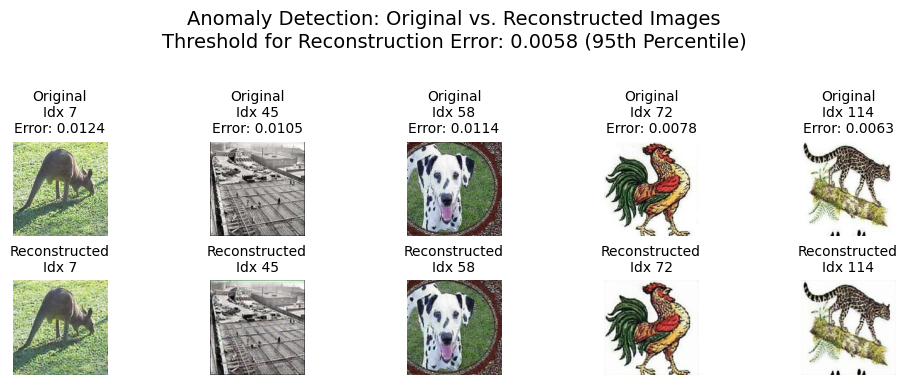

In [10]:
# Set figure size and define rows for original and reconstructed images
plt.figure(figsize=(10, 4))  # Adjust width and height as needed

# Add title for the entire plot
plt.suptitle("Anomaly Detection: Original vs. Reconstructed Images\n"
             f"Threshold for Reconstruction Error: {threshold:.4f} (95th Percentile)", fontsize=14, y=0.95)

# Iterate over the first 5 anomalous instances
for i, idx in enumerate(anomalous_indices[:5]):
    # Original image
    plt.subplot(2, 5, i + 1)  # Top row: original images
    plt.title(f"Original\nIdx {idx}\nError: {reconstruction_errors[idx]:.4f}", fontsize=10)
    plt.imshow(test_images[idx])
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, 5, i + 6)  # Bottom row: reconstructed images
    plt.title(f"Reconstructed\nIdx {idx}", fontsize=10)
    plt.imshow(reconstructed_images[idx])
    plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space for the main title
plt.show()

## 4. Actionable Recommendations


Specific Error Analysis for Index 7:
 - Top 10% high-error pixels: 3277.
 - Sample High-Error Pixels with Reconstruction Errors:
   Pixel (np.int64(0), np.int64(19)): Error = 0.0907
   Pixel (np.int64(0), np.int64(37)): Error = 0.0737
   Pixel (np.int64(0), np.int64(38)): Error = 0.0589
   Pixel (np.int64(0), np.int64(42)): Error = 0.0750
   Pixel (np.int64(0), np.int64(43)): Error = 0.0864
 - Recommendations:
   1. Focus on regions with the highest reconstruction errors.
   2. Examine the highlighted areas for potential defects or irregularities.
   3. Consider refining model or data to reduce errors in these regions.



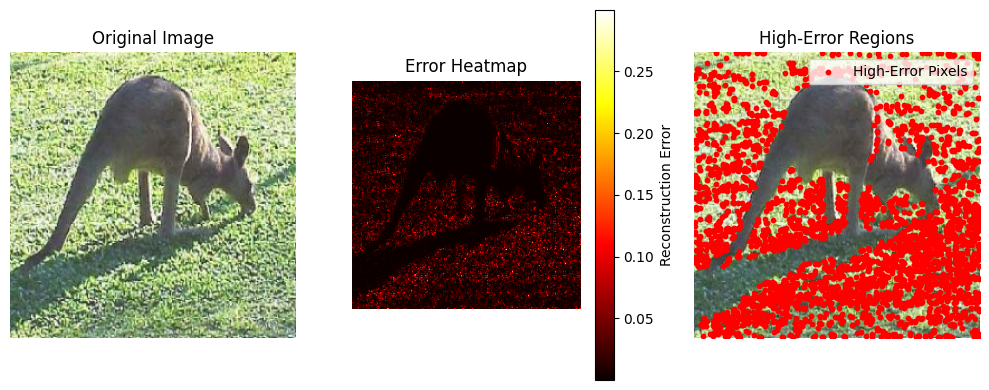


Specific Error Analysis for Index 45:
 - Top 10% high-error pixels: 3277.
 - Sample High-Error Pixels with Reconstruction Errors:
   Pixel (np.int64(0), np.int64(0)): Error = 0.1601
   Pixel (np.int64(0), np.int64(1)): Error = 0.0997
   Pixel (np.int64(0), np.int64(2)): Error = 0.1265
   Pixel (np.int64(0), np.int64(3)): Error = 0.1559
   Pixel (np.int64(0), np.int64(4)): Error = 0.1688
 - Recommendations:
   1. Focus on regions with the highest reconstruction errors.
   2. Examine the highlighted areas for potential defects or irregularities.
   3. Consider refining model or data to reduce errors in these regions.



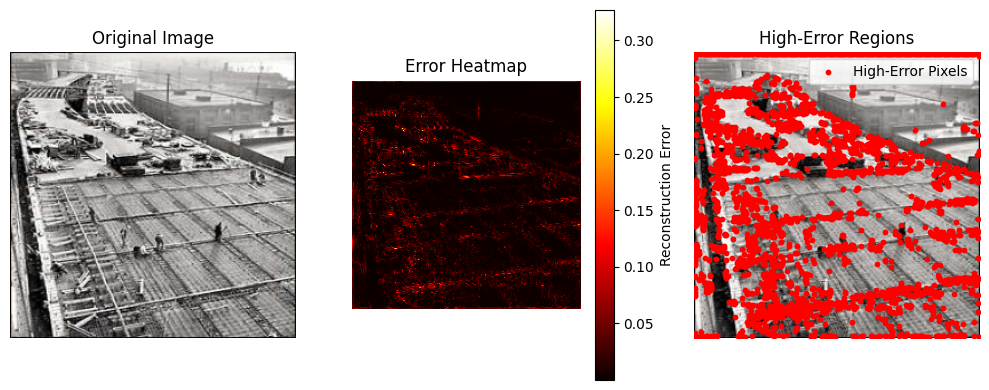


Specific Error Analysis for Index 58:
 - Top 10% high-error pixels: 3277.
 - Sample High-Error Pixels with Reconstruction Errors:
   Pixel (np.int64(0), np.int64(2)): Error = 0.0656
   Pixel (np.int64(0), np.int64(3)): Error = 0.0914
   Pixel (np.int64(0), np.int64(4)): Error = 0.1245
   Pixel (np.int64(0), np.int64(6)): Error = 0.3745
   Pixel (np.int64(0), np.int64(7)): Error = 0.3506
 - Recommendations:
   1. Focus on regions with the highest reconstruction errors.
   2. Examine the highlighted areas for potential defects or irregularities.
   3. Consider refining model or data to reduce errors in these regions.



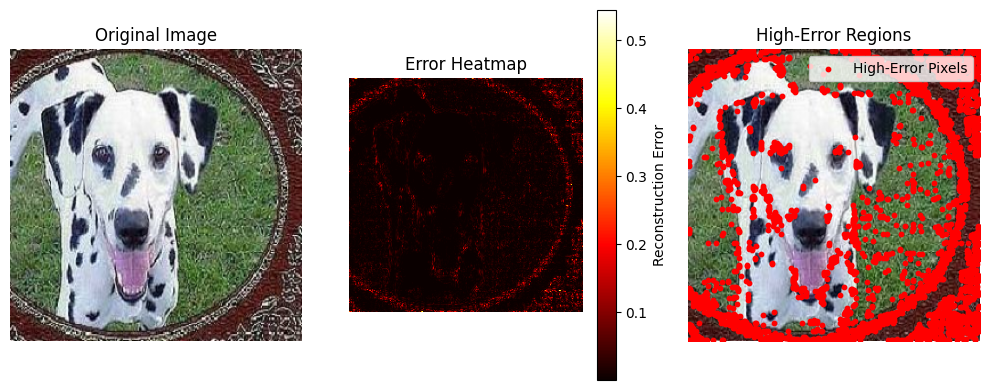


Specific Error Analysis for Index 72:
 - Top 10% high-error pixels: 3277.
 - Sample High-Error Pixels with Reconstruction Errors:
   Pixel (np.int64(5), np.int64(134)): Error = 0.0779
   Pixel (np.int64(6), np.int64(136)): Error = 0.0591
   Pixel (np.int64(7), np.int64(137)): Error = 0.0464
   Pixel (np.int64(7), np.int64(146)): Error = 0.0555
   Pixel (np.int64(8), np.int64(133)): Error = 0.0610
 - Recommendations:
   1. Focus on regions with the highest reconstruction errors.
   2. Examine the highlighted areas for potential defects or irregularities.
   3. Consider refining model or data to reduce errors in these regions.



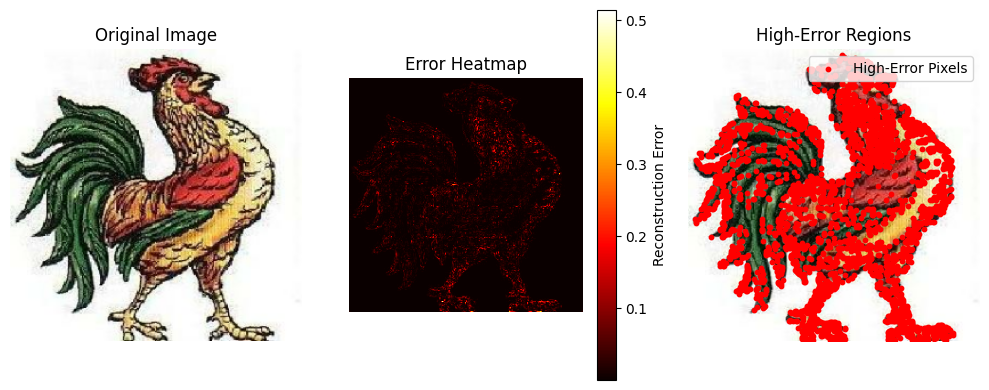


Specific Error Analysis for Index 114:
 - Top 10% high-error pixels: 3277.
 - Sample High-Error Pixels with Reconstruction Errors:
   Pixel (np.int64(12), np.int64(16)): Error = 0.0764
   Pixel (np.int64(12), np.int64(122)): Error = 0.0411
   Pixel (np.int64(13), np.int64(16)): Error = 0.0982
   Pixel (np.int64(13), np.int64(111)): Error = 0.0337
   Pixel (np.int64(13), np.int64(124)): Error = 0.0624
 - Recommendations:
   1. Focus on regions with the highest reconstruction errors.
   2. Examine the highlighted areas for potential defects or irregularities.
   3. Consider refining model or data to reduce errors in these regions.



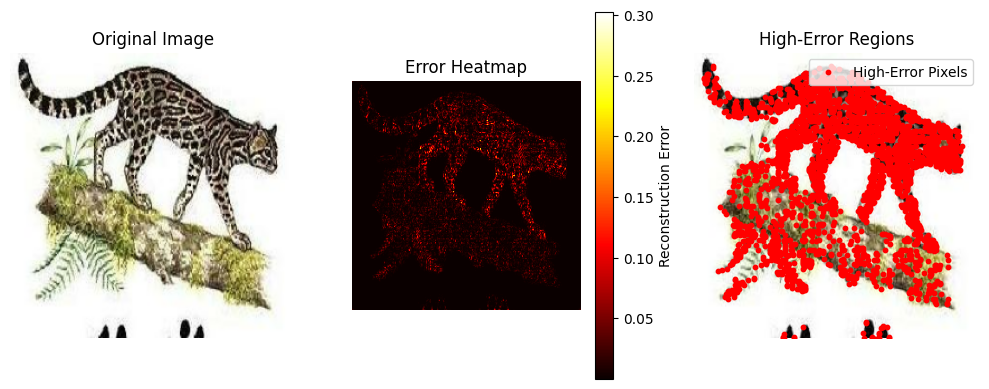

In [11]:
# Compute pixel-wise reconstruction errors
pixel_wise_errors = np.square(test_images - reconstructed_images)
aggregated_errors = np.mean(pixel_wise_errors, axis=-1)  # Aggregate error across channels

# Focus on anomalies
anomalous_pixel_errors = aggregated_errors[anomalous_indices]

# Helper function to analyze anomalies and provide specific reconstruction errors
def analyze_specific_errors(idx, error_map):    
    # Identify high-error regions (e.g., top 10% of pixels by error)
    threshold = np.percentile(error_map, 95)  # Top 10% threshold
    high_error_pixels = np.argwhere(error_map >= threshold)
    high_error_values = error_map[error_map >= threshold]

    # Generate analysis summary
    print(f"\nSpecific Error Analysis for Index {idx}:")
    print(f" - Top 10% high-error pixels: {len(high_error_pixels)}.")
    print(" - Sample High-Error Pixels with Reconstruction Errors:")
    for coord, error in zip(high_error_pixels[:5], high_error_values[:5]):
        print(f"   Pixel {tuple(coord)}: Error = {error:.4f}")

    print(" - Recommendations:")
    print("   1. Focus on regions with the highest reconstruction errors.")
    print("   2. Examine the highlighted areas for potential defects or irregularities.")
    print("   3. Consider refining model or data to reduce errors in these regions.")
    print()

    return high_error_pixels, high_error_values

# Visualize and analyze specific errors
for idx in anomalous_indices[:5]:  # Visualize the first 5 anomalies
    plt.figure(figsize=(10, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_images[idx])
    plt.axis('off')

    # Error heatmap
    plt.subplot(1, 3, 2)
    error_map = aggregated_errors[idx]
    plt.title("Error Heatmap")
    plt.imshow(error_map, cmap='hot')
    plt.colorbar(label="Reconstruction Error")
    plt.axis('off')

    # High-error scatter plot with specific errors
    plt.subplot(1, 3, 3)
    plt.title("High-Error Regions")
    plt.imshow(test_images[idx])
    high_error_pixels, high_error_values = analyze_specific_errors(idx, error_map)
    if len(high_error_pixels) > 0:
        y_coords, x_coords = zip(*high_error_pixels)
        plt.scatter(x_coords, y_coords, color='red', s=10, label="High-Error Pixels")
    plt.legend(loc="upper right")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## 5. Evaluation and Visualization 

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


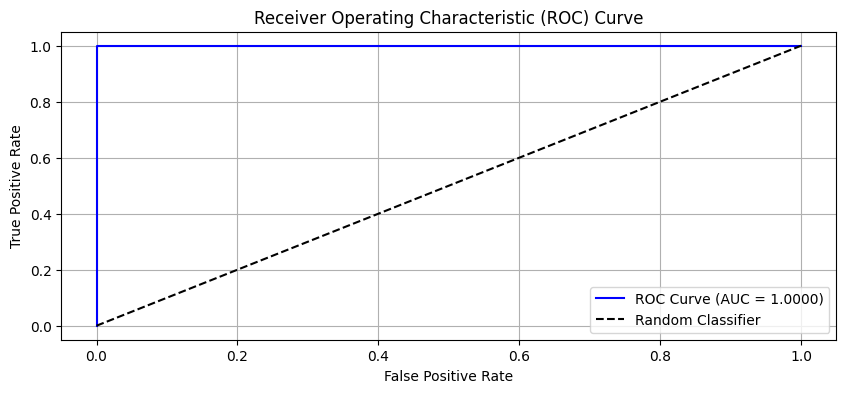

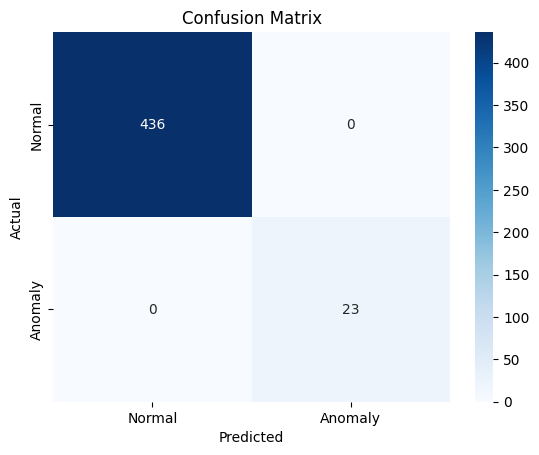

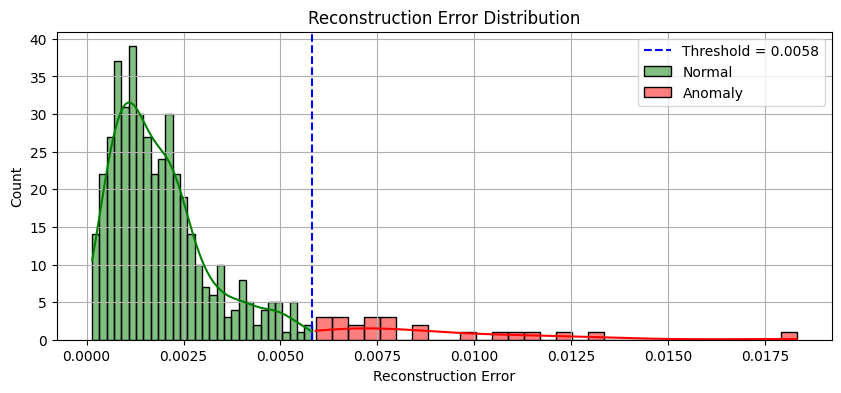

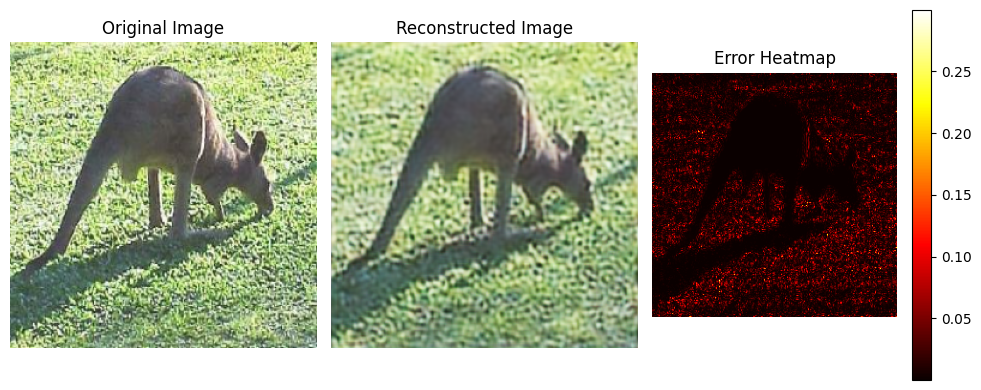

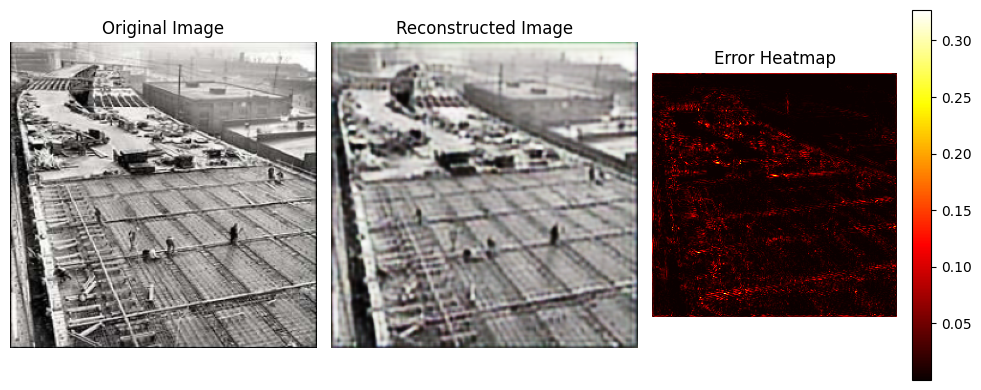

In [12]:

# Binary labels for test samples (0 = normal, 1 = anomaly)
true_labels = np.array([1 if idx in anomalous_indices else 0 for idx in range(len(test_images))])

# Metrics Calculation
predicted_labels = anomalies.astype(int)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Histogram of Reconstruction Errors
plt.figure(figsize=(10, 4))
sns.histplot(reconstruction_errors[true_labels == 0], bins=30, label="Normal", color="green", kde=True)
sns.histplot(reconstruction_errors[true_labels == 1], bins=30, label="Anomaly", color="red", kde=True)
plt.axvline(threshold, color="blue", linestyle="--", label=f"Threshold = {threshold:.4f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.grid()
plt.show()

# Visualization of Anomalies with Heatmaps
for idx in anomalous_indices[:2]:  # Visualize top 5 anomalies
    plt.figure(figsize=(10, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_images[idx])
    plt.axis("off")

    # Reconstructed image
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_images[idx])
    plt.axis("off")

    # Heatmap of reconstruction error
    pixel_wise_errors = np.square(test_images - reconstructed_images)
    aggregated_errors = np.mean(pixel_wise_errors, axis=-1)  # Aggregate error across channels
    plt.subplot(1, 3, 3)
    plt.title("Error Heatmap")
    plt.imshow(aggregated_errors[idx], cmap="hot")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()


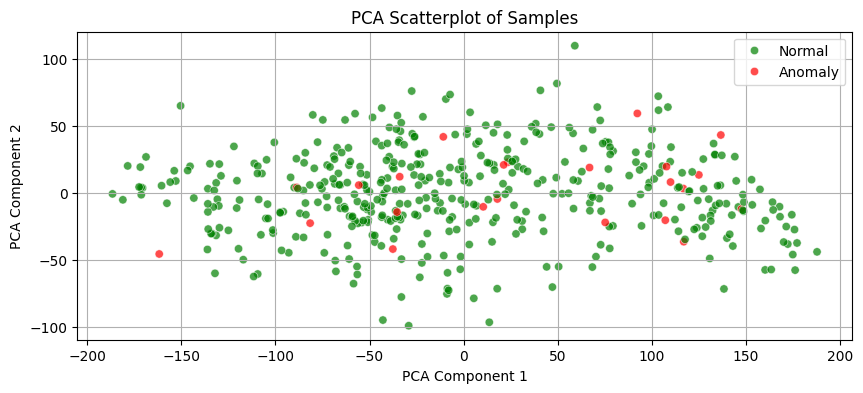

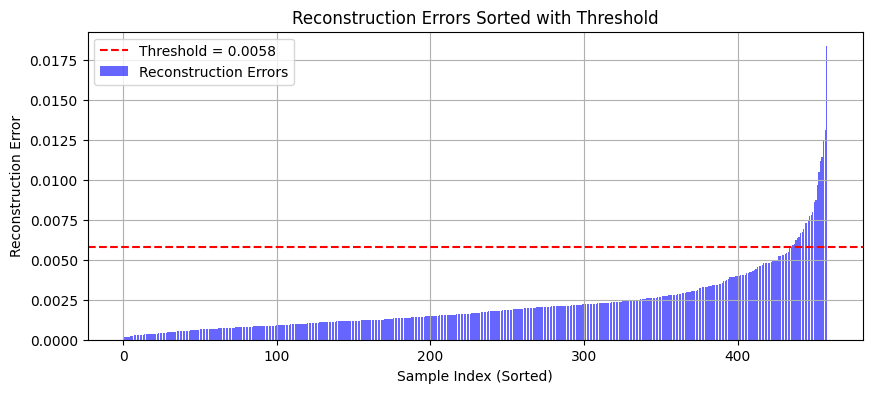

In [13]:
# Dimensionality Reduction (t-SNE/PCA Scatterplot)
# Combine reconstruction errors and labels into a data frame
import pandas as pd

data_embeddings = PCA(n_components=2).fit_transform(reconstructed_images.reshape(len(reconstructed_images), -1))
labels = ['Anomaly' if i in anomalous_indices else 'Normal' for i in range(len(test_images))]
df = pd.DataFrame(data_embeddings, columns=['Dim1', 'Dim2'])
df['Label'] = labels
df['Reconstruction_Error'] = reconstruction_errors

plt.figure(figsize=(10, 4))
sns.scatterplot(data=df, x='Dim1', y='Dim2', hue='Label', palette={"Normal": "green", "Anomaly": "red"}, alpha=0.7)
plt.title("PCA Scatterplot of Samples")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()

# Reconstruction Error Bar Chart
sorted_errors = np.sort(reconstruction_errors)
plt.figure(figsize=(10, 4))
plt.bar(range(len(sorted_errors)), sorted_errors, color='blue', alpha=0.6, label='Reconstruction Errors')
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Errors Sorted with Threshold")
plt.legend()
plt.grid()
plt.show()

## 6. Model Refinement and Optimization 

In this work, we experimented with various autoencoder architectures and hyperparameters to optimize performance. We trained multiple models, comparing their results to identify the most effective configuration. For comparison, we also included the results of the initial autoencoder architecture, which had a complex design and yielded poor results, to demonstrate the improvements achieved through iterative experimentation.

In [ ]:
# Experiment with different autoencoder architectures

def build_autoencoder(input_shape, encoding_dim=128, dropout_rate=0.3, reg_strength=0.01):
    input_img = layers.Input(shape=input_shape)

    # Encoder    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(reg_strength))(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 128 x 128 x 64
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(reg_strength))(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 64 x 64 x 128
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(reg_strength))(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32 x 32 x 256

    # Bottleneck (Latent Representation)
    x = layers.Flatten()(x)
    x = layers.Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(reg_strength))(x)

    # Decoder
    x = layers.Dense(32 * 32 * 256, activation='relu')(x)
    x = layers.Reshape((32, 32, 256))(x)  # Reshape to match the last pooling layer output
    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 64 x 64 x 256
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 128 x 128 x 128
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 256 x 256 x 64

    output_img = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)  # 256 x 256 x 3

    autoencoder = models.Model(input_img, output_img)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Hyperparameter tuning with reduced parameters for faster experimentation
def tune_autoencoder_hyperparameters(train_data, val_data, input_shape):
    param_grid = {
        'encoding_dim': [256],
        'dropout_rate': [0.3],
        'reg_strength': [0.01],
        'learning_rate': [1e-3],
        'batch_size': [32],
        'epochs': [10]
    }

    best_model = None
    best_loss = np.inf
    history_dict = {}

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")

        autoencoder = build_autoencoder(input_shape,
                                         encoding_dim=params['encoding_dim'],
                                         dropout_rate=params['dropout_rate'],
                                         reg_strength=params['reg_strength'])

        # Learning rate scheduling
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=params['learning_rate'],
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)

        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mse')


        history = autoencoder.fit(train_images, train_images, epochs=params['epochs'], batch_size=params['batch_size'],
                                  validation_data=(val_images, val_images), verbose=1)

        val_loss = history.history['val_loss'][-1]
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = autoencoder
            history_dict = history.history

    return best_model, history_dict

input_shape = (256, 256, 3)

# Tune hyperparameters and find the best model
best_model, history_dict = tune_autoencoder_hyperparameters(train_images, val_images, input_shape)

# Evaluate the model on test data
test_loss = best_model.evaluate(test_images, test_images, verbose=1)
print(f"Test Loss: {test_loss}")

# Save the best model
best_model.save('best_autoencoder_model1.keras')

Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'encoding_dim': 256, 'epochs': 10, 'learning_rate': 0.001, 'reg_strength': 0.01}
Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - loss: 2.1040 - val_loss: 0.1259
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - loss: 0.1143 - val_loss: 0.1080
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 278s 4s/step - loss: 0.1049 - val_loss: 0.1065
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - loss: 0.1037 - val_loss: 0.1069
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - loss: 0.1026 - val_loss: 0.1062
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - loss: 0.1016 - val_loss: 0.1062
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 279s 4s/step - loss: 0.1045 - val_loss: 0.1062
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - loss: 0.1029 - val_loss: 0.1062
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - loss: 0.1023 - val_loss: 0.1063
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - loss: 0.1029 - val_loss: 0.1063
15

In [18]:
# Load the saved models
model_paths = [
    "best_autoencoder_model1.keras",
    "best_autoencoder_improved2.keras",
    "best_autoencoder_improved3.keras"
]
models = [tf.keras.models.load_model(path) for path in model_paths]

print(f"Loaded {len(models)} models for comparison.")

Loaded 3 models for comparison.


In [19]:
def calculate_reconstruction_error(model, images):
  
    reconstructed = model.predict(images)
    error = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))  # Per-image error
    return np.mean(error), reconstructed  # Return mean error and reconstructed images

Evaluating Improved1...
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step
Evaluating Improved2...
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step
Evaluating Improved3...
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step
Model Improved1: Mean Reconstruction Error = 0.1030
Model Improved2: Mean Reconstruction Error = 0.0025
Model Improved3: Mean Reconstruction Error = 0.0022


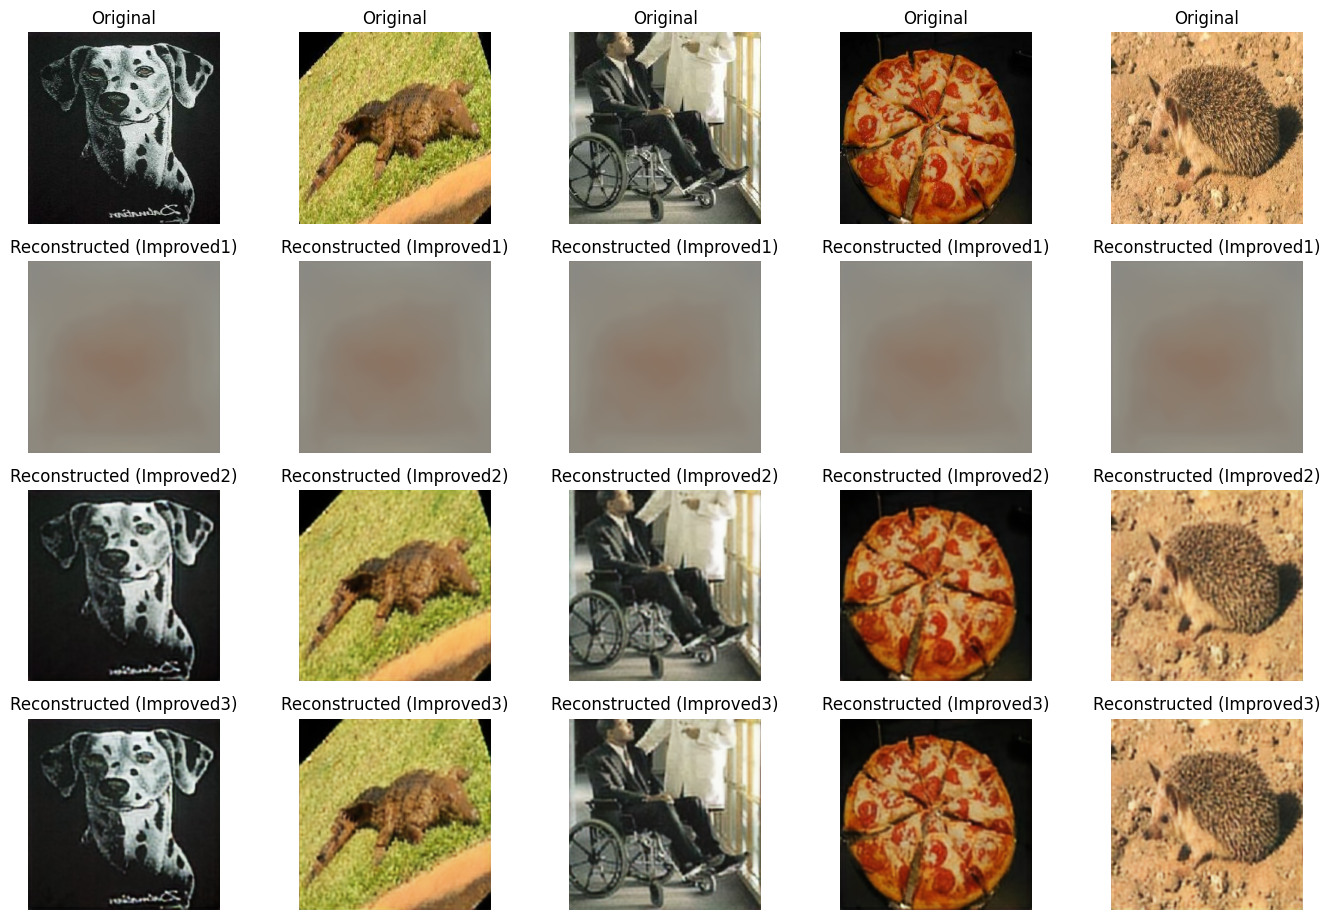

In [20]:
def visualize_comparisons(original_images, reconstructed_images_list, model_names, n=5):
  
    plt.figure(figsize=(14, 3.1 * len(reconstructed_images_list)))
    
    for i in range(n):
        # Original image
        ax = plt.subplot(len(reconstructed_images_list) + 1, n, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images from each model
        for j, (reconstructed_images, model_name) in enumerate(zip(reconstructed_images_list, model_names)):
            ax = plt.subplot(len(reconstructed_images_list) + 1, n, (j + 1) * n + i + 1)
            plt.imshow(reconstructed_images[i])
            plt.title(f"Reconstructed ({model_name})")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    # Store results
model_names = ["Improved1", "Improved2", "Improved3"]
errors = []
reconstructed_images_list = []

# Evaluate each model
for model, name in zip(models, model_names):
    print(f"Evaluating {name}...")
    error, reconstructed = calculate_reconstruction_error(model, test_images)
    errors.append(error)
    reconstructed_images_list.append(reconstructed)

# Print reconstruction errors
for name, error in zip(model_names, errors):
    print(f"Model {name}: Mean Reconstruction Error = {error:.4f}")

# Visualize comparisons
visualize_comparisons(test_images, reconstructed_images_list, model_names, n=5)

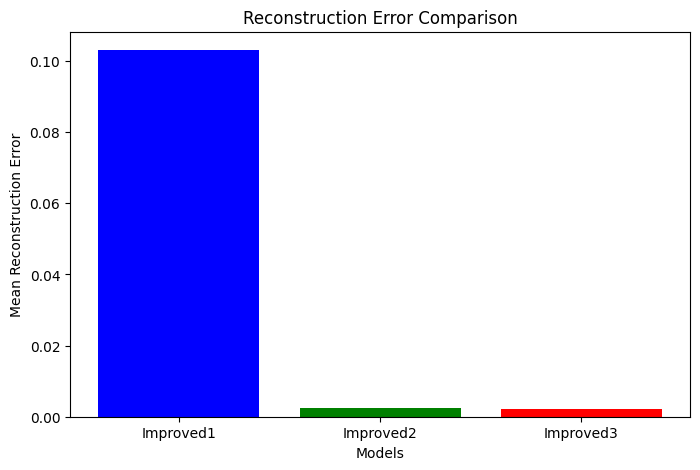

In [22]:
def plot_reconstruction_errors(model_names, errors):
  
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, errors, color=['blue', 'green', 'red'])
    plt.xlabel("Models")
    plt.ylabel("Mean Reconstruction Error")
    plt.title("Reconstruction Error Comparison")
    plt.show()

# Plot errors
plot_reconstruction_errors(model_names, errors)

Calculating accuracy for Improved1...
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 734ms/step
Model Improved1: Accuracy = 0.0632
Calculating accuracy for Improved2...
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step
Model Improved2: Accuracy = 0.9847
Calculating accuracy for Improved3...
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step
Model Improved3: Accuracy = 0.9869


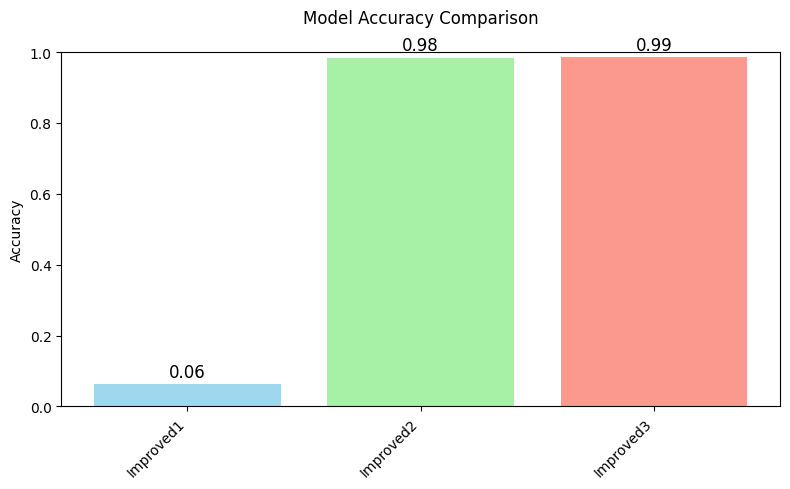

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def calculate_accuracy(model, images, threshold=0.01):

    reconstructed = model.predict(images)
    errors = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))  # Per-image MSE
    accuracy = np.mean(errors < threshold)  # Fraction of images with error below the threshold
    return accuracy

def plot_accuracy_bar_chart(model_names, accuracies):

    plt.figure(figsize=(8, 5))
    bar_positions = np.arange(len(model_names))
    colors = ['skyblue', 'lightgreen', 'salmon']  # Colors for bars
    plt.bar(bar_positions, accuracies, color=colors, alpha=0.8)
    plt.xticks(bar_positions, model_names, rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)  # Accuracy is between 0 and 1
    plt.title("Model Accuracy Comparison\n")
    for i, acc in enumerate(accuracies):
        plt.text(bar_positions[i], acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)  # Annotate bars
    plt.tight_layout()
    plt.show()

# Calculate accuracy for each model
threshold = 0.01  # Adjust the threshold for your use case
accuracies = []

for model, name in zip(models, model_names):
    print(f"Calculating accuracy for {name}...")
    accuracy = calculate_accuracy(model, test_images, threshold=threshold)
    accuracies.append(accuracy)
    print(f"Model {name}: Accuracy = {accuracy:.4f}")

# Plot accuracy comparison
plot_accuracy_bar_chart(model_names, accuracies)
